In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [ ]:
train_dir = "/content/drive/MyDrive/datasets/chest_xray/chest_xray/train"
test_dir = "/content/drive/MyDrive/datasets/chest_xray/chest_xray/test"
val_dir = "/content/drive/MyDrive/datasets/chest_xray/chest_xray/val"

In [ ]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("/content/drive/MyDrive/datasets/chest_xray/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/drive/MyDrive/datasets/chest_xray/chest_xray/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3876
NORMAL=1342

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=9
NORMAL=9


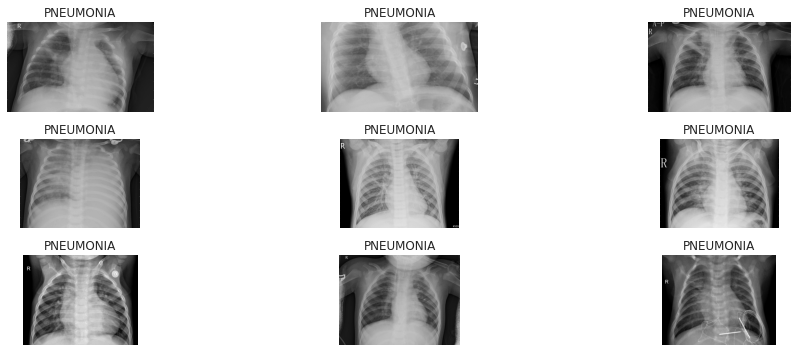

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

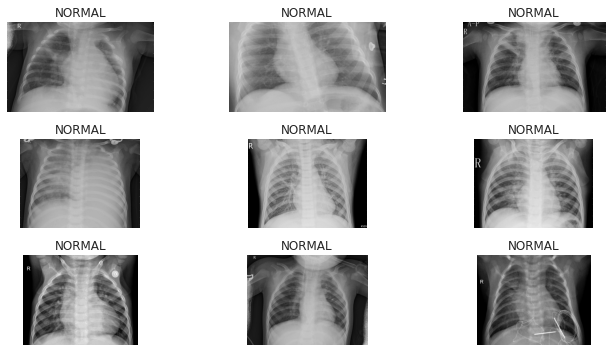

In [ ]:
normal = os.listdir("/content/drive/MyDrive/datasets/chest_xray/chest_xray/train/NORMAL")
normal_dir = "/content/drive/MyDrive/datasets/chest_xray/chest_xray/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [ ]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

In [ ]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

In [ ]:
data.head()

,class
0,0
1,0
2,0
3,0
4,0


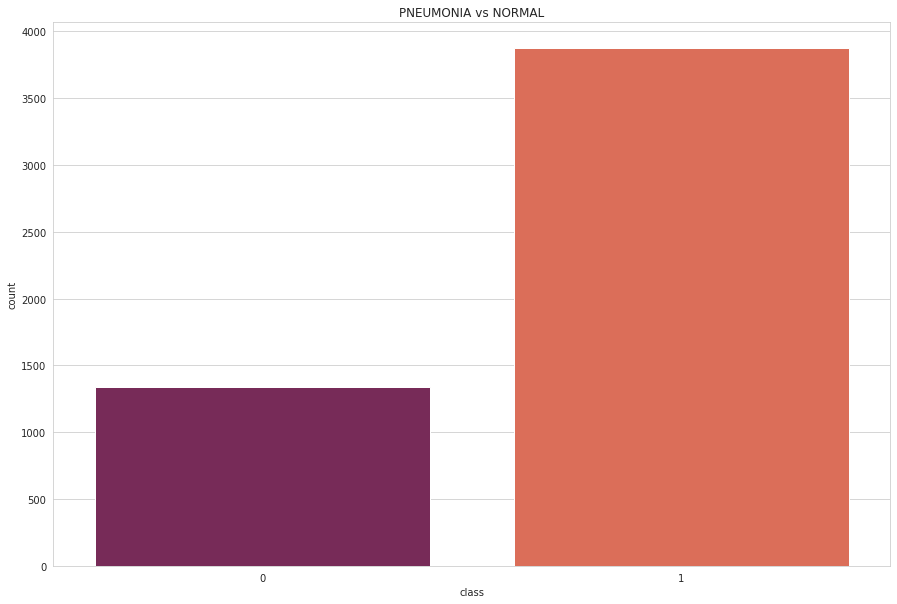

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

In [ ]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [ ]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
img, label = next(train)

In [ ]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 680s 6s/step - loss: 0.5057 - accuracy: 0.7581 - val_loss: 0.5416 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 297s 3s/step - loss: 0.4124 - accuracy: 0.8106 - val_loss: 0.4967 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 182s 2s/step - loss: 0.3928 - accuracy: 0.8181 - val_loss: 0.4918 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 139s 1s/step - loss: 0.3651 - accuracy: 0.8344 - val_loss: 0.4706 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 123s 1s/step - loss: 0.3386 - accuracy: 0.8478 - val_loss: 0.4215 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 113s 1s/step - loss: 0.3423 - accuracy: 0.8444 - val_loss: 0.4501 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 112s 1s/st

In [ ]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

163/163 [==============================] - 179s 1s/step - loss: 0.2229 - accuracy: 0.9053
Train Loss:  0.22289083898067474
Train Accuracy:  0.9052914381027222


In [ ]:

# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

312/312 [==============================] - 154s 493ms/step - loss: 0.3208 - accuracy: 0.8750
Test Loss:  0.32077687978744507
Test Accuracy:  0.875


Text(0.5, 1.0, 'Accuracy Evolution')

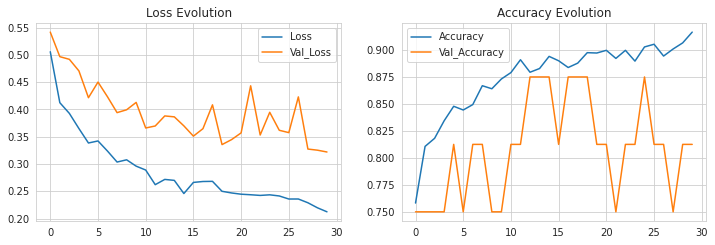

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

94683136/94668760 [==============================] - 3s 0us/step


In [ ]:
history = model2.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 115s 1s/step - loss: 0.3048 - accuracy: 0.8744 - val_loss: 0.1918 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 104s 1s/step - loss: 0.2042 - accuracy: 0.9134 - val_loss: 0.1612 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 106s 1s/step - loss: 0.1828 - accuracy: 0.9253 - val_loss: 0.1513 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 105s 1s/step - loss: 0.1854 - accuracy: 0.9212 - val_loss: 0.2688 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 111s 1s/step - loss: 0.1848 - accuracy: 0.9278 - val_loss: 0.2260 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 108s 1s/step - loss: 0.1679 - accuracy: 0.9344 - val_loss: 0.2100 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/30
100/100 [==============================] - 112s 1s/st

In [ ]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])s
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 175s 1s/step - loss: 0.1143 - accuracy: 0.9582
Train Loss:  0.1142825037240982
Train Accuracy:  0.95820552110672
312/312 [==============================] - 13s 43ms/step - loss: 0.2051 - accuracy: 0.9279

Test loss:  0.2050929218530655
Test Accuracy:  0.9278846383094788


Text(0.5, 1.0, 'Accuracy Evolution')

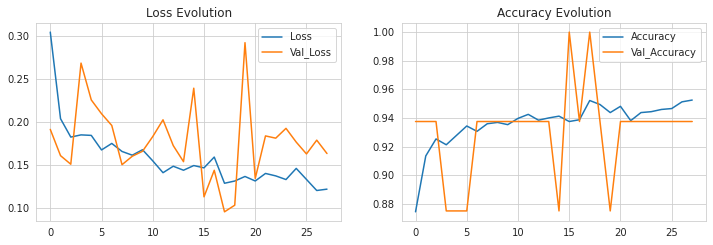

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
resnet_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [ ]:
#Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
len(model2.trainable_variables)

86

In [ ]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model2.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - 122s 1s/step - loss: 0.2968 - accuracy: 0.8881 - val_loss: 10.1004 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - 113s 1s/step - loss: 0.1910 - accuracy: 0.9284 - val_loss: 0.2082 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - 114s 1s/step - loss: 0.1783 - accuracy: 0.9356 - val_loss: 0.2629 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - 114s 1s/step - loss: 0.1663 - accuracy: 0.9362 - val_loss: 8.6553 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/40
100/100 [==============================] - 113s 1s/step - loss: 0.1450 - accuracy: 0.9409 - val_loss: 0.5635 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/40
100/100 [==============================] - 112s 1s/step - loss: 0.1388 - accuracy: 0.9513 - val_loss: 1.1612 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/40
100/100 [==============================] - 110s 1s/s

In [ ]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 179s 1s/step - loss: 0.0650 - accuracy: 0.9745
Train Loss:  0.06500270962715149
Train Accuracy:  0.9745015501976013
312/312 [==============================] - 13s 41ms/step - loss: 0.1724 - accuracy: 0.9439

Test loss:  0.1724172979593277
Test Accuracy:  0.9439102411270142


Text(0.5, 1.0, 'Accuracy Evolution')

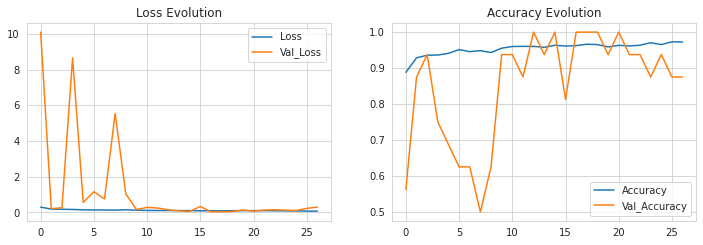

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
#After fine tuning on ResNet50V2 we got accuracy on test data is ~95%